In [1]:
%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate/Fig_config_utilities.py'

<class 'numpy.ndarray'> (3187, 16101)


In [2]:
# Spearman's rank heatmap correlation plots
def figure_5_rank_correlation(predictions_dict, 
                              output_path='/home/christianl/Zhang-Lab/Zhang Lab Code/Figures/'):
    """
    Generate heatmap of Spearman rank correlations between model predictions.
    This shows how similarly different models rank their predictions.
    
    Parameters
    ----------
    predictions_dict : dict
        Dictionary of predictions by model
        Example: {'MLR': mlr_y_pred, 'XGBRFRegressor': xgbrf_y_pred}
    output_path : str
        Path to save figure
        
    Returns
    -------
    corr_matrix : np.ndarray
        Correlation matrix between model predictions
    """
    set_publication_style()
    model_names = list(predictions_dict.keys())
    n_models = len(model_names)
    
    print("\n" + "="*80)
    print("PREDICTION RANK CORRELATION ANALYSIS")
    print("="*80)
    print("\nComputing Spearman rank correlations between model predictions...")
    print("(This measures how similarly models rank gene expression levels)\n")
    
    # compute pairwise Spearman correlations
    corr_matrix = np.zeros((n_models, n_models))
    p_matrix = np.zeros((n_models, n_models))
    
    for i in range(n_models):
        for j in range(n_models):
            if i == j:
                corr_matrix[i, j] = 1.0
                p_matrix[i, j] = 0.0
            else:
                # flattening predictions for correlation
                pred_i = predictions_dict[model_names[i]].ravel()
                pred_j = predictions_dict[model_names[j]].ravel()
                
                # compute Spearman rank correlation
                rho, p_val = spearmanr(pred_i, pred_j)
                corr_matrix[i, j] = rho
                p_matrix[i, j] = p_val
                
                print(f"{model_names[i]:15s} vs {model_names[j]:15s}: ρ = {rho:.4f}, p < {p_val:.2e}")
    
    # create figure
    fig, ax = plt.subplots(figsize=(8, 7))
    
    # color scale for model agreement
    vmin = max(0.5, corr_matrix[~np.eye(n_models, dtype=bool)].min() - 0.05)
    vmax = 1.0
    center = (vmin + vmax) / 2
    
    # create heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='RdYlGn',
               center=center, vmin=vmin, vmax=vmax,
               xticklabels=model_names, yticklabels=model_names,
               cbar_kws={'label': "Spearman's ρ"},
               linewidths=2, linecolor='white', ax=ax,
               annot_kws={'fontsize': 13, 'fontweight': 'bold'})  # FIX 3: Larger font
    
    ax.set_title("Rank Correlation Between Model Predictions\n(Spearman's ρ)", 
                fontsize=14, fontweight='bold', pad=20)
    
    # significance indicators
    for i in range(n_models):
        for j in range(n_models):
            if i != j:
                if p_matrix[i, j] < 0.001:
                    sig = '***'
                elif p_matrix[i, j] < 0.01:
                    sig = '**'
                elif p_matrix[i, j] < 0.05:
                    sig = '*'
                else:
                    sig = ''  # Don't show 'ns'
                
                if sig:
                    # FIX 5: Better positioning (below the number)
                    ax.text(j + 0.5, i + 0.75, sig, fontsize=14, 
                           ha='center', va='center', color='darkgreen', 
                           fontweight='bold')
    
    # interpretation guide
    interpretation = (
        "Interpretation:\n"
        "ρ > 0.95: Very high agreement\n"
        "ρ = 0.85-0.95: High agreement\n"
        "ρ = 0.70-0.85: Moderate agreement\n"
        "ρ < 0.70: Low agreement"
    )
    
    ax.text(1.02, 0.5, interpretation, transform=ax.transAxes,
           fontsize=9, verticalalignment='center',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
    print(f"\nFigure 5 saved to {output_path}")
    
    # summary stat
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    
    # off-diagonal correlations
    mask = ~np.eye(n_models, dtype=bool)
    off_diag = corr_matrix[mask]
    
    print(f"\nCorrelation statistics (off-diagonal):")
    print(f"  Mean: {off_diag.mean():.4f}")
    print(f"  Min:  {off_diag.min():.4f}")
    print(f"  Max:  {off_diag.max():.4f}")
    
    if off_diag.mean() > 0.95:
        print("\n→ Models show VERY HIGH agreement (likely learning same patterns)")
    elif off_diag.mean() > 0.85:
        print("\n→ Models show HIGH agreement (similar but not identical)")
    elif off_diag.mean() > 0.70:
        print("\n→ Models show MODERATE agreement (capturing some different signals)")
    else:
        print("\n→ Models show LOW agreement (capturing very different patterns)")
    
    print("="*80 + "\n")
    plt.show()
    
    return corr_matrix


PREDICTION RANK CORRELATION ANALYSIS

Computing Spearman rank correlations between model predictions...
(This measures how similarly models rank gene expression levels)

MLR             vs XGBRFRegressor : ρ = 0.5505, p < 0.00e+00
XGBRFRegressor  vs MLR            : ρ = 0.5505, p < 0.00e+00

Figure 5 saved to figure_5_v1.png

SUMMARY

Correlation statistics (off-diagonal):
  Mean: 0.5505
  Min:  0.5505
  Max:  0.5505

→ Models show LOW agreement (capturing very different patterns)



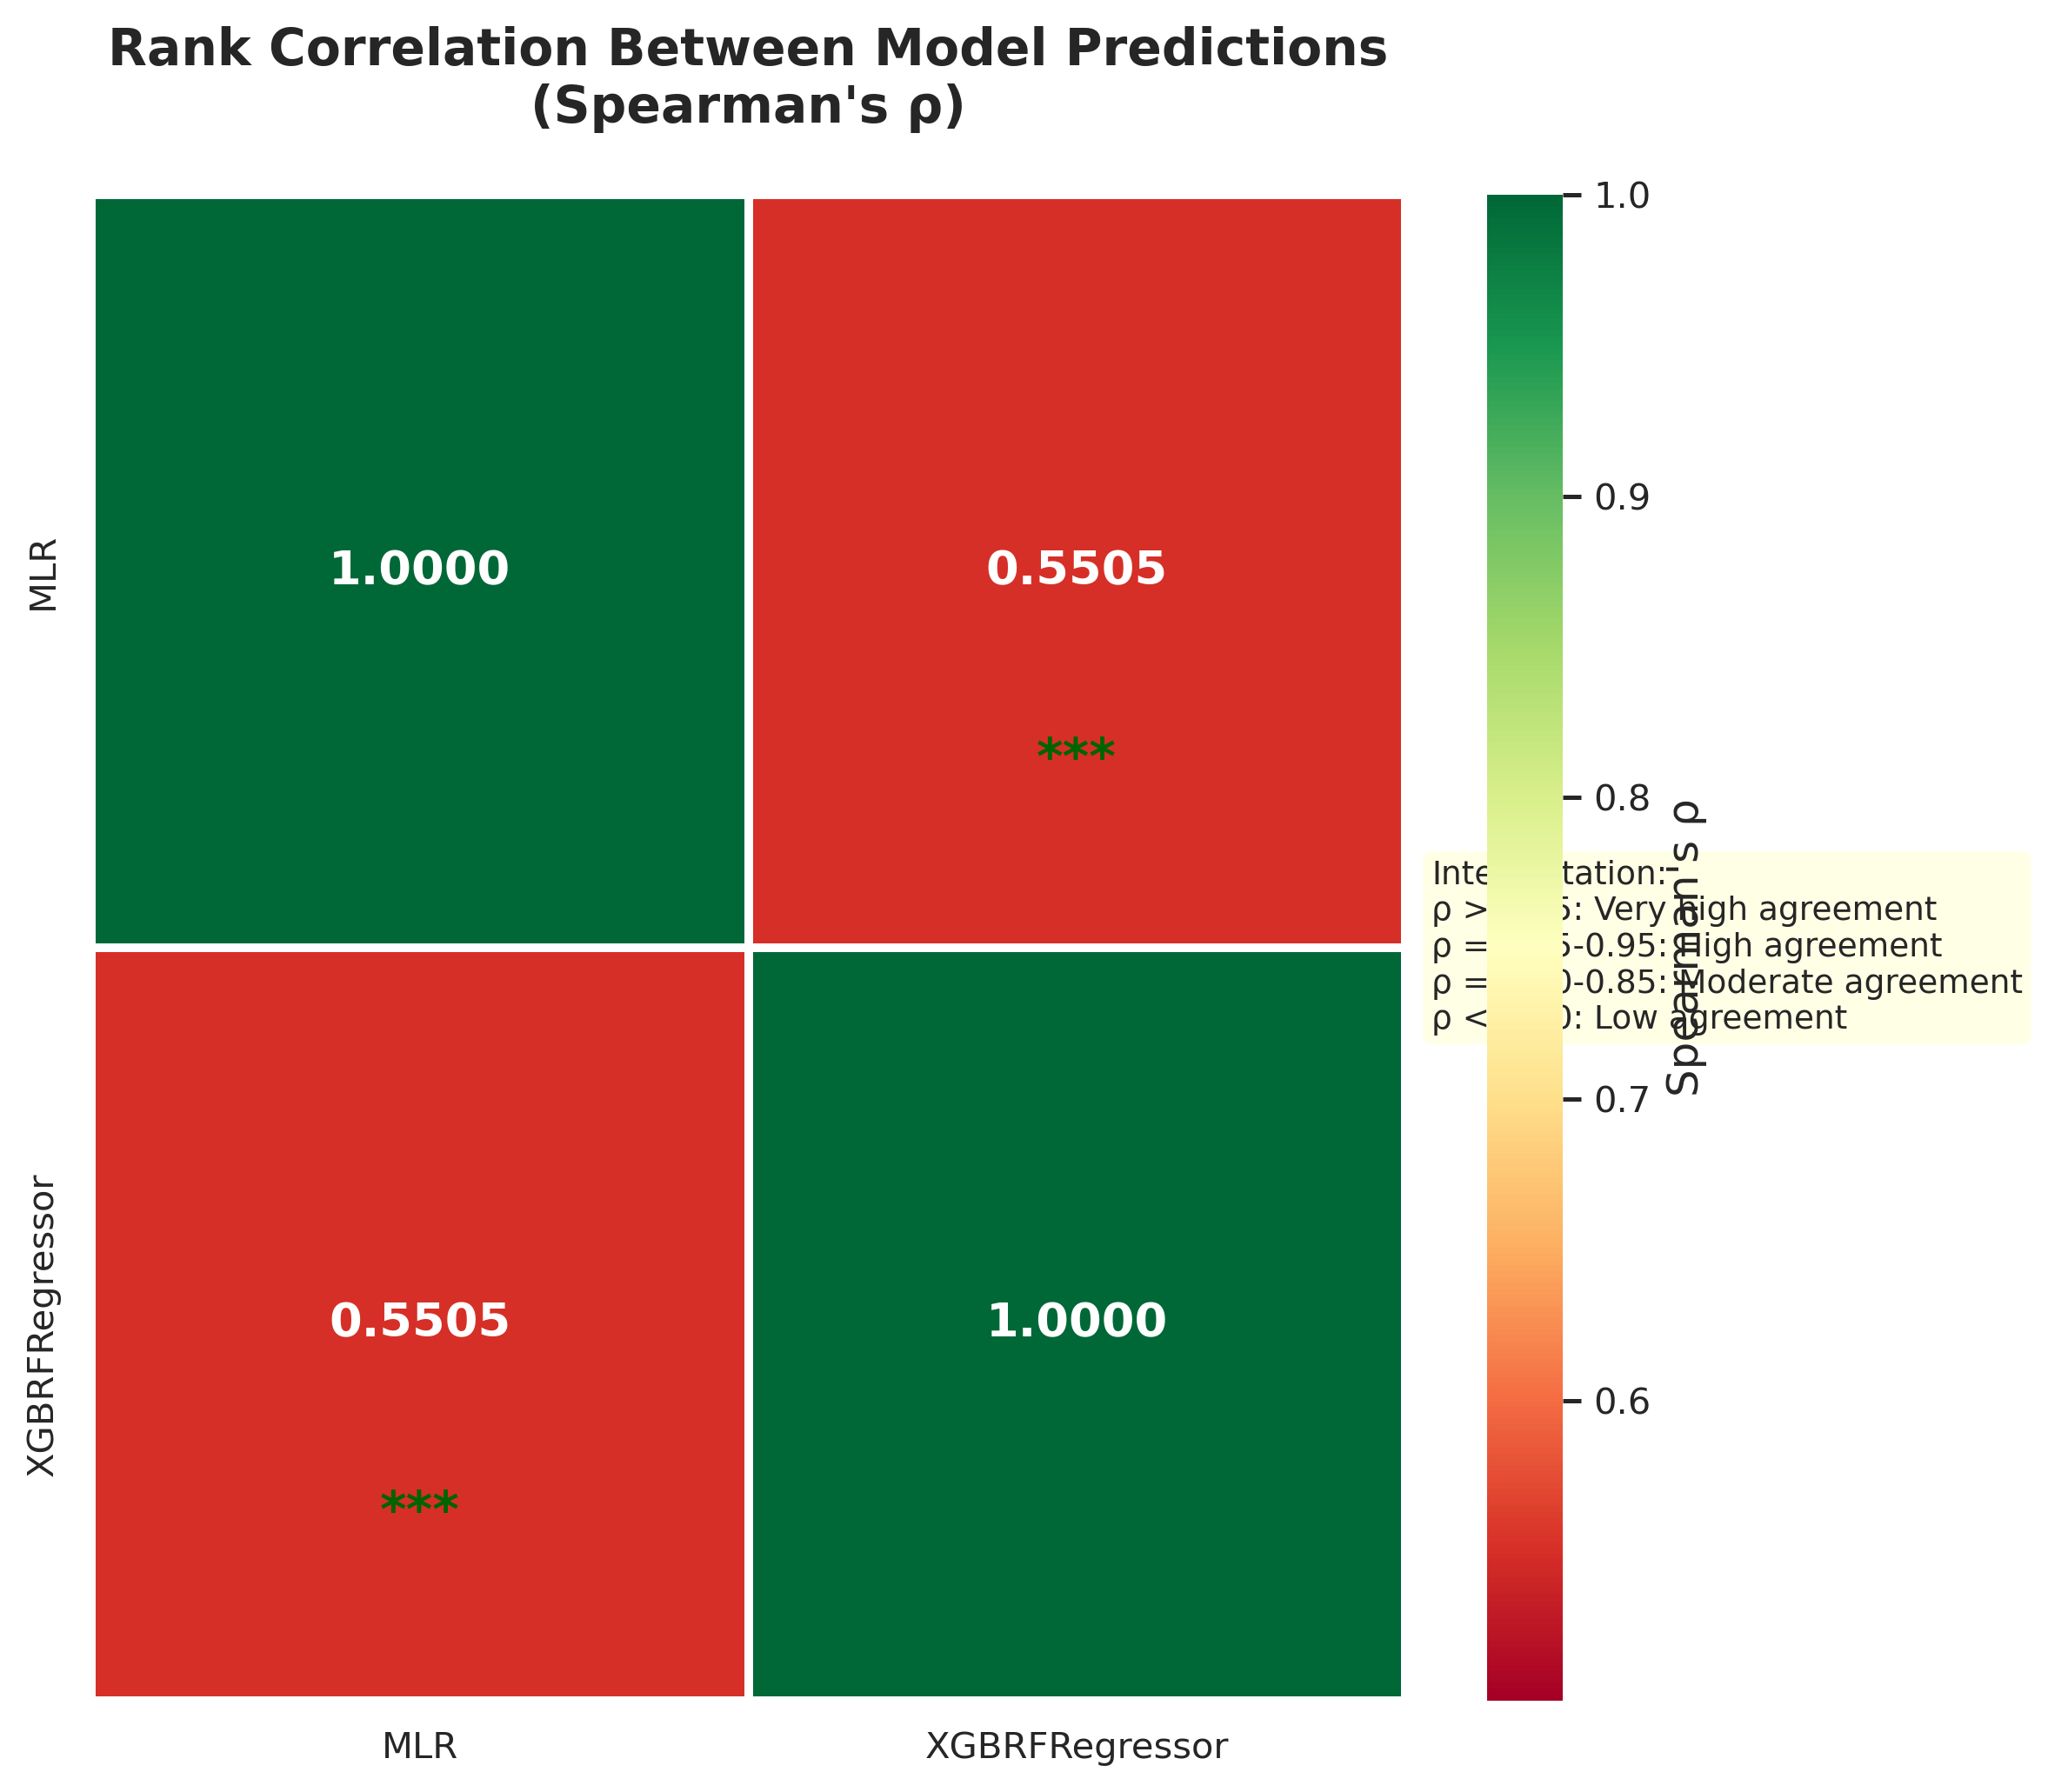

array([[1.        , 0.55046044],
       [0.55046044, 1.        ]])

In [3]:
figure_5_rank_correlation(predictions,'figure_5_v1.png')